### Imports

In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import time
import os
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as mpltPath
from matplotlib.collections import PatchCollection
from matplotlib.animation import FuncAnimation
from shapely.geometry import Polygon, box, LineString, Point
from shapely.ops import unary_union
from scipy.spatial import Voronoi, cKDTree, voronoi_plot_2d, ConvexHull
from concurrent.futures import ProcessPoolExecutor, as_completed

# imports from the utils.py script
import utils as NFLUtils

## Methods

### Organizing and cleaning game data

In [43]:
def load_game_data(tracking_file_path: str, plays_file_path: str, game_id: int, chunk_size:int = 10000)->pd.DataFrame:
    """
    Load rows from a CSV file that match a specific gameID

    Args:
    file_path (str): Path to the CSV file
    game_id (int): the gameID to filter by
    chunk_size (int, optional): the number of rows per chunk, default 10000

    Returns:
    pd.DataFrame: a DataFrame containing rows with the specified gameID
    """
    data = pd.DataFrame()
    # stream data in chunks
    for chunk in pd.read_csv(tracking_file_path, chunksize=chunk_size):
        filtered_chunk = chunk[chunk['gameId'] == game_id]
        # when no more matches, don't parse the rest of the file
        if filtered_chunk.shape[0] == 0:
            break
        data = pd.concat([data, filtered_chunk], ignore_index=True)
    plays_df = pd.read_csv(plays_file_path)
    data = pd.merge(data, plays_df[['gameId', 'playId', 'possessionTeam', 'ballCarrierId']], on=['gameId', 'playId'])
    data = data.loc[data['club'] != 'football']
    data['is_offense'] = (data['possessionTeam'] == data['club'])
    return data

In [45]:
def organize_game_data(df: pd.DataFrame)->dict:
    """
    Organize game data into a nested dictionary structure.

    Args:
    df (pd.DataFrame): The DataFrame containing game data.

    Returns:
    dict: A nested dictionary with plays as keys and dictionaries of data where the key is the frame and the values are data from that frame
    """

    # Initialize the main dictionary
    game_dict = {}

    # Iterate over each unique play in the DataFrame
    for play_id in df['playId'].unique():

        play_df = df[df['playId'] == play_id]
        play_events = play_df['event'].unique()


        #for now, ignoring fumbles, but maybe later on we can count that as a tackle?
        if 'fumble' in play_events:
          continue
        
        play_df = play_df.copy()
        if play_df['playDirection'].iloc[0] == 'left':
          play_df['x'] = 120 - play_df['x']
          play_df['y'] = 53.3 - play_df['y']


        # Initialize the play's dictionary
        play_dict = {}

        start_frame = 1
        #another potentiall type of event to include is 'run', but for now i'm excluding that
        #because I'm not exactly sure what it means
        if 'pass_outcome_caught' in play_events:
          start_frame = play_df.loc[play_df['event'] == 'pass_outcome_caught']['frameId'].min()
        elif 'handoff' in play_events:
          start_frame = play_df.loc[play_df['event'] == 'handoff']['frameId'].min()
        else:
          continue

        #this limits us to plays where a tackle is made
        #not sure if we need special consideration for when a runner scores, so those plays are ignored for now
        #potentially could include 'out_of_bounds' and factor that into defensive play as well
        end_frame = 1
        if 'tackle' in play_events:
          end_frame = play_df.loc[play_df['event'] == 'tackle']['frameId'].min()
        else:
          continue

        # Iterate over each player in the play
        for frame_id in play_df['frameId'].unique():
            if (frame_id < start_frame) or (frame_id > end_frame):
              continue
            frame_df = play_df[play_df['frameId'] == frame_id]

            # Select and sort relevant columns
            columns = ['nflId', 'time', 'playDirection', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'event', 'is_offense', 'ballCarrierId']
            frame_df = frame_df[columns]
            frame_df = frame_df.astype({'nflId': int, 'ballCarrierId': int})
            
            # Add the player's DataFrame to the play's dictionary
            play_dict[frame_id] = frame_df

        # Add the play's dictionary to the main dictionary
        game_dict[play_id] = play_dict

    return game_dict

### Voronoi Utils

In [13]:
def generate_color_map(nfl_ids):
    """
    Generates a color map for given NFL IDs.

    Parameters:
    - nfl_ids: List of unique NFL IDs.

    Returns:
    - Dictionary mapping each NFL ID to a color.
    """
    nfl_ids = nfl_ids.dropna().unique()
    colors = plt.cm.rainbow(np.linspace(0, 1, len(nfl_ids)))
    color_map = {nfl_id: color for nfl_id, color in zip(nfl_ids, colors)}
    return color_map

In [14]:
def assign_squares_to_players_OLD(frame_data, x_min=0, x_max=120, y_min=0, y_max=53.3):
    # TODO: MADE THIS PRETTY SLOW. We can cache the results of the find_closest_player function embedded to make this faster down the line
    """
    DEPRACATED. UPDATE METHOD BELOW
    Assigns each 1-yard square of a football field to the nearest player.

    Parameters:
    - frame_data (pd.DataFrame): DataFrame with columns ['nflId', 'x', 'y'] representing players' positions.
    - x_min, x_max (float): Optional. The minimum and maximum x-coordinates (in yards) of the field area to consider.(0-120 yards)
    - y_min, y_max (float): Optional. The minimum and maximum y-coordinates (in yards) of the field area to consider.(0-53.3 yards)

    Returns:
    - A DataFrame with columns ['square_x', 'square_y', 'closest_player_id'].
    """
    
    # Generate all 1-yard squares within specified limits
    x_range = np.arange(x_min, x_max + 1, 1)
    y_range = np.arange(y_min, y_max + 1, 1)
    squares = pd.DataFrame([(x, y) for x in x_range for y in y_range], columns=['square_x', 'square_y'])

    # Function to find the closest player for a given square
    def find_closest_player(square_x, square_y):
        frame_data['distance'] = np.sqrt((frame_data['x'] - square_x) ** 2 + (frame_data['y'] - square_y) ** 2)
        return frame_data.loc[frame_data['distance'].idxmin()]['nflId']

    # Assign each square to the closest player
    squares['closest_player_id'] = squares.apply(lambda row: find_closest_player(row['square_x'], row['square_y']), axis=1)

    # Drop the temporary distance column from frame_data
    frame_data.drop(columns=['distance'], inplace=True)

    return squares

In [56]:
def in_box(players, bounding_box):
    """ 
    Check if a point is in a box (works in conjunction with calculate_voronoi_areas)
    Params: 
    - players (np.array()): a 2D array of the coordinates of all the players
    - bounding_box (tuple): the coordinates of the bounds in the form (x_min, x_max, y_min, y_max)
    """
    return np.logical_and(np.logical_and(bounding_box[0] <= players[:, 0],
                                         players[:, 0] <= bounding_box[1]),
                          np.logical_and(bounding_box[2] <= players[:, 1],
                                         players[:, 1] <= bounding_box[3]))

In [57]:
def calculate_voronoi_areas(df, x_min:float=None, x_max=110, y_min=0, y_max=53.3): 
    """
    Take 2: use mirroring to solve
    df (pd.DataFrame): the data frame of frame_data from the organize_game_data method
    x_min (float): the minimum x value at which we end analysis
    x_max (float): default 100 because that's the endzone, the amount of defended territory
    y_min (float), y_max(float): bounds for y
    """
    
    # create a boundary 10 yards behind the ball carrier or 10 yds (start of endzone), whichever is greater
    if not x_min: 
        x_min = max(df[df.nflId==df.ballCarrierId.iloc[0]].x.iloc[0] - 10, 10)

    df_filtered = df[df['x'].between(x_min, x_max) & df['y'].between(y_min, y_max)]
    players = df_filtered[['x', 'y']].to_numpy()

    bounding_box = (x_min, x_max, y_min, y_max)
    # Select towers inside the bounding box
    i = in_box(players, bounding_box)
    # Mirror points
    points_center = players[i, :]
    points_left = np.copy(points_center)
    points_left[:, 0] = bounding_box[0] - (points_left[:, 0] - bounding_box[0])
    points_right = np.copy(points_center)
    points_right[:, 0] = bounding_box[1] + (bounding_box[1] - points_right[:, 0])
    points_down = np.copy(points_center)
    points_down[:, 1] = bounding_box[2] - (points_down[:, 1] - bounding_box[2])
    points_up = np.copy(points_center)
    points_up[:, 1] = bounding_box[3] + (bounding_box[3] - points_up[:, 1])
    points = np.append(points_center,
                       np.append(np.append(points_left,
                                           points_right,
                                           axis=0),
                                 np.append(points_down,
                                           points_up,
                                           axis=0),
                                 axis=0),
                       axis=0)
    # Compute Voronoi
    vor = sp.spatial.Voronoi(points)
    # Filter regions
    regions = []
    [vor.point_region[i] for i in range(10)]

    vor.filtered_points = points_center
    vor.filtered_regions = [vor.regions[vor.point_region[i]] for i in range(len(points_center))]
    areas = [ConvexHull(vor.vertices[vor.filtered_regions[idx], :]).volume for idx in range(len(vor.filtered_regions))]  # pull the areas and zip them to the vertices passed in
    
    return dict(zip(df_filtered.nflId, areas))

In [18]:
def assign_squares_to_players(frame_data, x_min=0, x_max=110, y_min=0, y_max=53.3, x_step=1, y_step=1):
    """
    Assigns each x_step by y_step square of a football field to the nearest player using Voronoi tessellation.

    Parameters:
    - frame_data (pd.DataFrame): DataFrame with columns ['nflId', 'x', 'y'] representing players' positions.
    - x_min, x_max (float): Optional. The minimum and maximum x-coordinates (in yards) of the field area to consider.(0-120 yards)
    - y_min, y_max (float): Optional. The minimum and maximum y-coordinates (in yards) of the field area to consider.(0-53.3 yards)
    - x_step, y_step (float): Optional. The size of each Voronoi bucket, defaults to 1 yd by 1 yd

    Returns:
    - A DataFrame with columns ['square_x', 'square_y', 'closest_player_id', 'ball_carrier', 'is_offense'].
    """
    # modify the frame_data such that ever offensive player gets the ballCarrierId (assume they share voronoi space)
    # commenting this out for the moment because it wasn't helping the analysis, but in the future, make it such that if they're touching the space of another offensive player they become one unit
    ball_carrier = frame_data.ballCarrierId.iloc[0]
    # frame_data.loc[frame_data.is_offense == True, 'nflId'] = ball_carrier

    # Generate Voronoi diagram
    points = frame_data[['x', 'y']].values
    vor = Voronoi(points)
    # fig = voronoi_plot_2d(vor)
    # plt.show()  # for debug purposes 

    # Generate all 1-yard squares within specified limits
    x_range = np.arange(x_min, x_max + x_step, x_step)
    y_range = np.arange(y_min, y_max + y_step, y_step)
    squares = pd.DataFrame([(x, y) for x in x_range for y in y_range], columns=['square_x', 'square_y'])

    # Create a KDTree for efficient nearest neighbor search
    tree = cKDTree(points)

    # Assign each square to the closest player based on Voronoi regions
    squares['closest_player_id'] = squares.apply(lambda row: frame_data.iloc[tree.query((row['square_x'], row['square_y']))[1]]['nflId'], axis=1)
    # get the ID of the ball carrier
    squares['ball_carrier'] = ball_carrier

    return squares


In [19]:
def voronoi_area(squares:pd.DataFrame, weights:pd.DataFrame=None):
    """
    Return the area attributed to each unique player by nflID

    Params: 
    - squares (pd.DataFrame): a dataframe with columns ['square_x', 'square_y', 'closest_player_id'].
    - weights (pd.DataFrame): 

    Returns: 
    - a dictionary with keys of closest_player_id and values of the voronoi areas, in square yards (we can modify this later with the weights)
    """
    # this is the case where we weight each Voronoi bin differently -- we can implement this later
    if weights: 
        return 
    else:
        voronoi_areas = squares.groupby('closest_player_id').size().to_dict()
    
    return voronoi_areas


In [20]:
def visualize_field(frame:pd.DataFrame, x_min, color_map:dict=None, x_max=110, y_min=0, y_max=53.3, x_step=1, y_step=1):

    if not color_map: 
        color_map = generate_color_map(frame.nflId)

    # Create a figure and axis for the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Process the frame data to get the assignments
    player_assignments = assign_squares_to_players(frame, x_min, x_max, y_min, y_max, x_step, y_step)
    ball_carrier = frame.ballCarrierId.iloc[0]

    ax.clear()
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Create a list to hold all the rectangles
    rectangles = []

    # Create a list to hold the colors of each rectangle
    rectangle_colors = []

    for _, row in player_assignments.iterrows():

        # plot the colors based on the closest player
        player_id = row['closest_player_id']
        square_color = color_map.get(player_id, 'grey')
        rect = patches.Rectangle((row['square_x'] - 0.5, row['square_y'] - 0.5), 1, 1)
        rectangles.append(rect)
        rectangle_colors.append(square_color)

    # Add labels at centroids
    player_positions = zip(frame.nflId, frame.is_offense, frame.x, frame.y)
    for player_id, is_offense, x, y in player_positions:

        # Get tackle percentage contribution, default 0 for offense
        tpc = voronoi_area(player_assignments).get(player_id, 0) 

        # label the offensive players, red=ball carrier, black=offense, white=defense
        if player_id == ball_carrier: 
            dot_color='red'
        elif is_offense: 
            dot_color='black'
        else: 
            dot_color='white'

        # plot the dot for every player and their TPC
        ax.plot(x, y, marker='o', markersize=5, markerfacecolor=dot_color)
        ax.text(x, y, f'{player_id}: {tpc}', ha='center', va='center', fontsize=9)
    # Create a PatchCollection and add it to the axis
    pc = PatchCollection(rectangles, facecolor=rectangle_colors, edgecolor=None)
    ax.add_collection(pc)

    # Additional plot settings
    ax.set_xlabel('Yards (X-axis)')
    ax.set_ylabel('Yards (Y-axis)')
    ax.set_title(f'Bucketed Voronoi Areas (ball carrier: {ball_carrier})')

### Tackle Percentage Contribution

In [69]:
def tackle_percentage_contribution_per_frame(frame_data:pd.DataFrame, x_step: int=1, y_step: int=1)->dict:
    """ 
    For every unique player attributed to a square on the defending team, take them out and see how much Voronoi area would be gained by the player in possession. 

    Params: 
    - frame_data (pd.DataFrame): a dataframe from the organize_game_data method with columns ['nflId', 'ballCarrierId', 'is_offense', 'x', 'y']
    - x_step (int): the x-side of the voronoi bins when caling the assign_squres_to_players method
    - y_step (int): the y-side of the voronoi bins when caling the assign_squres_to_players method

    Returns: 
    - dictionary with keys of nflId and value of the tackle percentage contribution for that frame
    """
    
    area_protected = {}
    # get the ball carrier and offensive players
    ball_carrier = frame_data.ballCarrierId.iloc[0]
    offensive_players = dict(zip(frame_data.nflId, frame_data.is_offense))

    # get the minimum x, after which we will cut off voronoi analysis
    x_min = max(10, frame_data.loc[frame_data.nflId==ball_carrier, 'x'].iloc[0] - 10) # we end the voronoi tesselation 10 yards behind the ball carrier or 10, whichever is greater
    baseline_area = calculate_voronoi_areas(frame_data, x_min=x_min).get(ball_carrier,0)
    # squares = assign_squares_to_players(frame_data, x_min=x_min, x_step=x_step, y_step=y_step)
    # baseline_area = voronoi_area(squares)[ball_carrier]
    
    for player_id in frame_data.nflId.unique(): 
        # break for the ball_carrier     
        if offensive_players[player_id]: 
            continue
        # take the frame data if that player didn't exist
        filtered_frame_data = frame_data[frame_data.nflId != player_id]
        protected_areas = calculate_voronoi_areas(filtered_frame_data, x_min=x_min).get(ball_carrier,0)
        # calculate how much additional space the offense gets
        # voronoi_filtered = assign_squares_to_players(filtered_frame_data, x_min=x_min, x_step=x_step, y_step=y_step)
        # protected_areas = voronoi_area(voronoi_filtered)[ball_carrier]
        area_protected[player_id] = protected_areas - baseline_area  # how much more area do they get?
    
    # divide by the total sum of the frame to get tackle percentage contribution in each frame
    # I'm unconvinced this is the correct approach and I'm commenting out out for now, we can talk about this
    # Basically, if no one is close to the player on offense, I think this will be misleading
    # total_protected_area = sum(area_protected.values())
    # for key, value in area_protected.items(): 
    #     area_protected[key] = value / total_protected_area

    return area_protected



In [68]:
def tackle_percentage_contribution_per_play(frame_dict:dict, filepath:str, x_step:int=1, y_step:int=1, animation:bool=False): 
    """
    This iterates through the frames in any given play and calculates the tackle percentage contribution of each player
    
    Params: 
    - frame_dict: dict from the organize_game_data method for each play
    - filepath (str): the filepath of the folder under which we are caching play data
    - x_step (int): the x-side of the voronoi bins when caling the assign_squres_to_players method
    - y_step (int): the y-side of the voronoi bins when caling the assign_squres_to_players method
    - animation (bool): whether or not we want to make an MP4 of the play

    Returns: 
    - dictionary with keys of nflId and value of the tackle percentage contribution for that play
    """
    # empty dict, one indexed by player, the other indexed by frame
    total_tpc = {}
    tpc_per_frame = {}

    # sort the frames
    frame_dict_sorted = sorted(frame_dict.items(), key=lambda x: x[0])
    # iterate through the frames of the play
    for key, frame in frame_dict_sorted: 

        # get protected areas, append to both dictionaries
        frame_tpc = tackle_percentage_contribution_per_frame(frame, x_step, y_step)
        tpc_per_frame[key] = frame_tpc

        # append to the overall dict for the play
        for player, contribution in frame_tpc.items():
            if player in total_tpc.keys(): 
                total_tpc[player] += contribution
            else: 
                total_tpc[player] = contribution
    
    # normalize every player's contribution such that it sums to 1
    total_protected_area = sum(total_tpc.values())
    for key, value in total_tpc.items():
        total_tpc[key] = value / total_protected_area


    # Convert the dictionary with the frame data to a DataFrame to cache
    # The keys of the outer dict become the index, and the inner dicts' keys become the column names
    tpc_per_frame_df = pd.DataFrame.from_dict(tpc_per_frame, orient='index')

    # Save to CSV, with the index to make future multiplication easier
    tpc_per_frame_df.to_csv(f'{filepath}/tpc_per_frame_updated_voronoi.csv', index=True)

    # cast everything to strings from int64 (otherwise cannot store in JSON)
    total_tpc_converted = {str(key): value for key, value in total_tpc.items()}

    # cache this result as a JSON for each play
    json.dump(total_tpc_converted, open(filepath+'/tpc_updated_voronoi.json', 'w'))

    # create an animation
    if animation: 
        create_animation(frame_dict=frame_dict, tpc_per_frame=tpc_per_frame, play_filepath=filepath, x_step=x_step, y_step=y_step)

    return total_tpc

In [64]:
def tackle_percentage_contribution_per_game_DEPRACATED(game_data_organized:dict, x_step:int=1, y_step:int=1): 
    """
    Iterate through all plays in the game and sum the defensive contribution of each player
    """
    game_tpc = {}
    # sort the plays in the game by the order they happened
    sorted_game_data_organized = sorted(game_data_organized.items(), key=lambda x: x[1])
    for key, play in sorted_game_data_organized: 
        print(key)  # for debugging purposes
        play_tpc = tackle_percentage_contribution_per_play(play)
        # append to the overall dict for the play
        for player, contribution in play_tpc.items():
            if player in game_tpc.keys(): 
                game_tpc[player] += contribution
            else: 
                game_tpc[player] = contribution

    return game_tpc


In [27]:
def create_animation(frame_dict: dict, tpc_per_frame: dict, play_filepath:str, x_min=0, x_max=120, y_min=0, y_max=53.3, x_step=1, y_step=1):
    """
    Creates an animation of bucketed Voronoi spaces for different frames.

    Parameters:
    - frame_dict: Dictionary of DataFrames indexed by frame, each containing ['player_id', 'x', 'y'].
    - tpc_per_frame (dict): returned from the tackle_percentage_contribution_per_play method that labels the contribution of each defensive player per play, each key is the frame
    - play_filepath (str): the filepath used to save the animation 
    - min_x (float): the min x value in the graph (long side of football field, 0-120)
    - max_x (float): the max x
    - min_y (float): the min y value in the graph (short axis of football field, 0-53.3)
    - max_y (float): the max y
    - frame (int): the frame in question, useful for locating the file
    
    Returns:
    - None

    """
    # assign a color map for all players in the play, based on which players were active in the first frame
    color_map = generate_color_map(frame_dict[sorted(frame_dict.keys())[0]].nflId) # from the first frame, pull all active players

    # open plots were taking too much memory
    plt.close('all')

    # Function to draw a single frame for the animation
    def draw_frame(frame_number):
        
        # Process the frame data to get the assignments
        player_assignments = assign_squares_to_players(frame_dict[frame_number], x_min, x_max, y_min, y_max, x_step, y_step)
        ball_carrier = frame_dict[frame_number].ballCarrierId.iloc[0]

        nonlocal color_map
        ax.clear()
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        # Create a list to hold all the rectangles
        rectangles = []

        # Create a list to hold the colors of each rectangle
        rectangle_colors = []

        for _, row in player_assignments.iterrows():

            # plot the colors based on the closest player
            player_id = row['closest_player_id']
            square_color = color_map.get(player_id, 'grey')
            rect = patches.Rectangle((row['square_x'] - 0.5, row['square_y'] - 0.5), 1, 1)
            rectangles.append(rect)
            rectangle_colors.append(square_color)

        # Add labels at centroids
        player_positions = zip(frame_dict[frame_number].nflId, frame_dict[frame_number].is_offense, frame_dict[frame_number].x, frame_dict[frame_number].y)
        for player_id, is_offense, x, y in player_positions:

            # Get tackle percentage contribution, default 0 for offense
            tpc = tpc_per_frame[frame_number].get(player_id, 0) 

            # label the offensive players, red=ball carrier, black=offense, white=defense
            if player_id == ball_carrier: 
                dot_color='red'
            elif is_offense: 
                dot_color='black'
            else: 
                dot_color='white'

            # plot the dot for every player and their TPC
            ax.plot(x, y, marker='o', markersize=5, markerfacecolor=dot_color)
            ax.text(x, y, f'{player_id}: {tpc}', ha='center', va='center', fontsize=9)
        # Create a PatchCollection and add it to the axis
        pc = PatchCollection(rectangles, facecolor=rectangle_colors, edgecolor=None)
        ax.add_collection(pc)

        # Additional plot settings
        ax.set_xlabel('Yards (X-axis)')
        ax.set_ylabel('Yards (Y-axis)')
        ax.set_title(f'Bucketed Voronoi Areas (ball carrier: {ball_carrier})')

    # Create figure and axis for the animation
    fig, ax = plt.subplots(figsize=(24, 12))

    # Create the animation
    anim = FuncAnimation(fig, draw_frame, frames=sorted(frame_dict.keys()), interval=200, repeat=False)

    # To save the animation, uncomment the line below and specify the filename and writer
    anim.save(play_filepath + f'/voronoi_visualizer.mp4', writer='ffmpeg')

    # plt.show()
    # return anim



In [70]:
def analyze_play(key, play, filepath, x_step, y_step, animation):
    """
    Wrapper function to analyze a single play. This function will be executed in parallel.
    Params: 
    - key (int): the play number
    - play (dict): a dictionary of the frames (pd.DataFrame) of each play
    - filepath (str): the filepath of tha game within which we will save information/animations of the play
    - x_step, y_step (float): the x/y step of each of the voronoi bins
    """
    print(key)  # For debugging purposes

    # Define the play's file path
    play_filepath = f'{filepath}/{key}'
    if not os.path.exists(play_filepath):
        os.makedirs(play_filepath)

    try:
        # Calculate the tackle_percentage_contribution
        # Ensure that the tackle_percentage_contribution_per_play function is defined appropriately
        play_tpc = tackle_percentage_contribution_per_play(frame_dict=play, filepath=play_filepath, x_step=x_step, y_step=y_step, animation=animation)

        return {player: contribution for player, contribution in play_tpc.items()}
    except Exception as e:
        print(f'Error processing play {key}: {e}')
        return {}


In [25]:
def analyze_game(game_id, tracking_file, x_step=1, y_step=1, plays_file='./data/plays.csv', players_file='./data/players.csv', game_file='./data/games.csv', animation:bool=False):
    """ 
    A method to analyze a game. Calling this will analyze and cache all the plays + the results of the analysis
    Param: 
    - game_id (int): the ID of the game as found in the Kaggle cleaned data
    - tracking_file (str): the address of the file in which the tracking data is stored
    - x_step, y_step (float): the x and y steps of each of the voronoi bins
    - plays_file (str): the address of the plays file
    - players_file (str): the filepath of the file containing players [TODO: CURRENTLY UNUSED.]
    - game_file (str): the filepath of the file containing information about each game
    """
    
    games = pd.read_csv(game_file)
    game_data = games[games.gameId==game_id].iloc[0, [0, 5, 6]] # pull the ID (col 0), home team (col 5), visitng team (col 6)
    filepath = f'./games/{game_data.iloc[0]}_{game_data.iloc[1]}_{game_data.iloc[2]}'

    # Create a directory for the game if none exists
    if not os.path.exists(filepath):
        os.makedirs(filepath)

    # Sort and organize the data
    game_data_organized = organize_game_data(load_game_data(tracking_file, plays_file, game_id))
    sorted_game_data_organized = sorted(game_data_organized.items(), key=lambda x: x[0])

    # Dictionary to store the overall tackle_percentage_contribution
    game_tpc = {}

    # Using ProcessPoolExecutor to parallelize the loop
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(analyze_play, key, play, filepath, x_step, y_step, animation) for key, play in sorted_game_data_organized]

        for future in as_completed(futures):
            play_tpc = future.result()
            for player, contribution in play_tpc.items():
                game_tpc[player] = game_tpc.get(player, 0) + contribution

    # Convert game_tpc keys from int64 to string to store in JSON
    game_tpc_converted = {str(key): value for key, value in game_tpc.items()}

    # Cache this result as a JSON for each game
    json.dump(game_tpc_converted, open(filepath + '/game_tpc_updated_voronoi.json', 'w'))

    return game_tpc

In [66]:
def analyze_game_unparallelized(game_id, tracking_file, x_step=1, y_step=1, plays_file='./data/plays.csv', players_file='./data/players.csv', game_file='./data/games.csv', animation:bool=False):
    """ 
    A method to analyze a game. Calling this will analyze and cache all the plays + the results of the analysis
    Param: 
    - game_id (int): the ID of the game as found in the Kaggle cleaned data
    - tracking_file (str): the address of the file in which the tracking data is stored
    - x_step, y_step (float): the x and y steps of each of the voronoi bins
    - plays_file (str): the address of the plays file
    - players_file (str): the filepath of the file containing players [TODO: CURRENTLY UNUSED.]
    - game_file (str): the filepath of the file containing information about each game
    """
    
    games = pd.read_csv(game_file)
    game_data = games[games.gameId==game_id].iloc[0, [0, 5, 6]] # pull the ID (col 0), home team (col 5), visitng team (col 6)
    filepath = f'./games/{game_data.iloc[0]}_{game_data.iloc[1]}_{game_data.iloc[2]}'

    # Create a directory for the game if none exists
    if not os.path.exists(filepath):
        os.makedirs(filepath)

    # Sort and organize the data
    game_data_organized = organize_game_data(load_game_data(tracking_file, plays_file, game_id))
    sorted_game_data_organized = sorted(game_data_organized.items(), key=lambda x: x[0])

    # Dictionary to store the overall tackle_percentage_contribution
    game_tpc = {}

    for key, play in sorted_game_data_organized: 
        play_tpc = analyze_play(key, play, filepath, x_step, y_step, animation)
        for player, contribution in play_tpc.items():
            game_tpc[player] = game_tpc.get(player, 0) + contribution

    # Convert game_tpc keys from int64 to string to store in JSON
    game_tpc_converted = {str(key): value for key, value in game_tpc.items()}

    # Cache this result as a JSON for each game
    json.dump(game_tpc_converted, open(filepath + '/game_tpc_updated_voronoi.json', 'w'))

    return game_tpc

### Distance analysis methods

In [28]:
def euclidean_distance_per_frame(frame_data:pd.DataFrame)->dict: 
    """ 
    Params: 
    - frame_data (pd.DataFrame): a dataframe from the organize_game_data method with columns ['nflId', 'ballCarrierId', 'is_offense', 'x', 'y']
    Returns: 
    - distance_dict (dict): a dict where the keys are the player IDs and the values are the distances
    """
    ball_carrier = frame_data.ballCarrierId.iloc[0]
    x, y = frame_data[frame_data.nflId==ball_carrier][['x', 'y']].iloc[0]
    defense = frame_data[~frame_data.is_offense].nflId
    distances = [np.sqrt((x-x_d)**2 + (y-y_d)**2) for x_d, y_d in zip(frame_data[~frame_data.is_offense].x, frame_data[~frame_data.is_offense].y)]
    distance_dict = dict(zip(defense, distances))

    return distance_dict

In [29]:
def euclidean_distance_per_play(frame_dict:dict, filepath:str)->dict: 
    """ 
    Calculate the Euclidean distances of each of the defenders from the ball
    Params: 
    - frame_dict: dict from the organize_game_data method for each play
    - filepath: the path of each play, under which we can cache the data
    """
    # Create a directory for the game if none exists
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    frame_distances = {}
    
    # sort the frames
    frame_dict_sorted = sorted(frame_dict.items(), key=lambda x: x[0])
    # iterate through the frames of the play
    for key, frame in frame_dict_sorted: 
        frame_distances[key] = euclidean_distance_per_frame(frame)

    # Convert the dictionary with the frame data to a DataFrame to cache
    # The keys of the outer dict become the index, and the inner dicts' keys become the column names
    frame_distances_df = pd.DataFrame.from_dict(frame_distances, orient='index')

    # Save to CSV, with the index to make future multiplication easier
    frame_distances_df.to_csv(f'{filepath}/distances_per_frame.csv', index=True)
    
    return frame_distances

In [30]:
def analyze_game_distances(game_id, tracking_file, plays_file='./data/plays.csv', game_file='./data/games.csv')->None:
    """ 
    A method to cache the distances of the players from the ball at all times
    Params: 
    - game_id (int): the ID of the game as found in the Kaggle cleaned data
    - tracking_file (str): the address of the file in which the tracking data is stored
    - plays_file (str): the address of the plays file
    - game_file (str): the filepath of the file containing information about each game
    """
    # read information about all the games
    games = pd.read_csv(game_file)
    game_data = games[games.gameId==game_id].iloc[0, [0, 5, 6]] # pull the ID (col 0), home team (col 5), visitng team (col 6)
    filepath = f'./games/{game_data.iloc[0]}_{game_data.iloc[1]}_{game_data.iloc[2]}'

    # Create a directory for the game if none exists
    if not os.path.exists(filepath):
        os.makedirs(filepath)

    # Sort and organize the data
    game_data_organized = organize_game_data(load_game_data(tracking_file, plays_file, game_id))
    sorted_game_data_organized = sorted(game_data_organized.items(), key=lambda x: x[0])

    # Using ProcessPoolExecutor to parallelize the loop
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(euclidean_distance_per_play, play, f'{filepath}/{key}') for key, play in sorted_game_data_organized]


### Pull game data

In [22]:
def get_game_stats(game_id:int, tackles_filepath:str='./data/tackles.csv')->dict: 
    """
    Given a game, get the total number of tackles and assists for every player; use this as a way to validate data
    Param: 
    - game_id (int): a 10 digit number where the first 8 are f'YYYYMMDD{ID}' and ID will be between 00 and 08
    - tackles_filepath (str): the filepath of the csv file with 
    Returns; 
    - tackles_dict: indexed by nflId
    - assists_dict: indexed by nflID
    """
    game_data = pd.read_csv(tackles_filepath)
    filtered_game_data = game_data[game_data.gameId == game_id].loc[:,['tackle', 'assist', 'nflId']].groupby(['nflId']).sum()
    
    return dict(zip(filtered_game_data.index, filtered_game_data.tackle)), dict(zip(filtered_game_data.index, filtered_game_data.assist))


## Implementation

### Sanity check methods

In [48]:
week_1_tracking_file = './data/tracking_week_1.csv'
plays_file = './data/plays.csv'
game_data = load_game_data(week_1_tracking_file, plays_file, 2022090800)
game_data_organized = organize_game_data(game_data)
print("Number of plays: ", len(game_data_organized.keys()))

# format of the organized data: 
test_frame = game_data_organized[56][7]
test_frame.head(10)

Number of plays:  67


,nflId,time,playDirection,x,y,s,a,dis,o,dir,event,is_offense,ballCarrierId
6,35472,2022-09-08 20:24:05.799999,left,31.13,26.66,0.93,1.69,0.09,235.77,134.32,NaN,True,42489
28,38577,2022-09-08 20:24:05.799999,left,41.90,24.22,3.52,1.83,0.34,345.22,359.37,NaN,False,42489
50,41239,2022-09-08 20:24:05.799999,left,27.74,23.67,3.40,3.07,0.35,188.44,162.73,NaN,False,42489
72,42392,2022-09-08 20:24:05.799999,left,31.82,23.85,1.46,0.36,0.15,286.98,345.97,NaN,True,42489
94,42489,2022-09-08 20:24:05.799999,left,40.31,18.10,4.01,5.10,0.41,111.79,204.77,NaN,True,42489
116,42816,2022-09-08 20:24:05.799999,left,49.59,45.56,2.26,4.46,0.23,337.15,291.94,NaN,False,42489
138,43294,2022-09-08 20:24:05.799999,left,41.83,16.02,5.62,1.87,0.57,142.18,178.89,NaN,False,42489
160,43298,2022-09-08 20:24:05.799999,left,27.95,20.28,1.38,1.63,0.13,159.91,210.17,NaN,False,42489
182,43335,2022-09-08 20:24:05.799999,left,31.68,27.66,1.05,1.92,0.09,0.24,260.32,NaN,False,42489
204,44875,2022-09-08 20:24:05.799999,left,30.12,27.05,0.63,1.85,0.07,257.44,0.71,NaN,True,42489


In [ ]:
# types of events in any given game
for key, play in game_data_organized.items(): 
    events = []
    for key2, value in play.items(): 
        events += [item for item in value.event]
        print(set(events))
set(events)

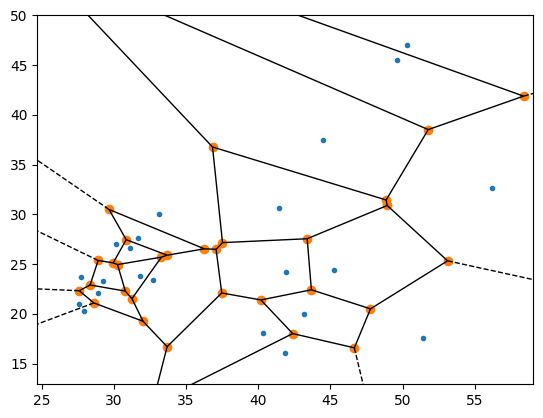

In [138]:
# voronoi tesselation
points = np.column_stack([test_frame['x'].to_numpy(), test_frame['y'].to_numpy()])
vor = Voronoi(points)
fig = voronoi_plot_2d(vor)
plt.show()
    

In [49]:
areas = calculate_voronoi_areas(test_frame, x_min=30, x_max=110, y_min=0, y_max=53.3)

In [50]:
x_min = max(test_frame[test_frame.nflId==test_frame.ballCarrierId.iloc[0]].x.iloc[0] - 10, 10)
squares = assign_squares_to_players(test_frame, x_min=x_min, x_step=1, y_step=1)
squares.head()

,square_x,square_y,closest_player_id,ball_carrier
0,30.31,0.0,43294,42489
1,30.31,1.0,43294,42489
2,30.31,2.0,43294,42489
3,30.31,3.0,43294,42489
4,30.31,4.0,43298,42489


In [51]:
voronoi_areas = voronoi_area(squares)

In [134]:
sum(v for v in voronoi_areas.values())

4455

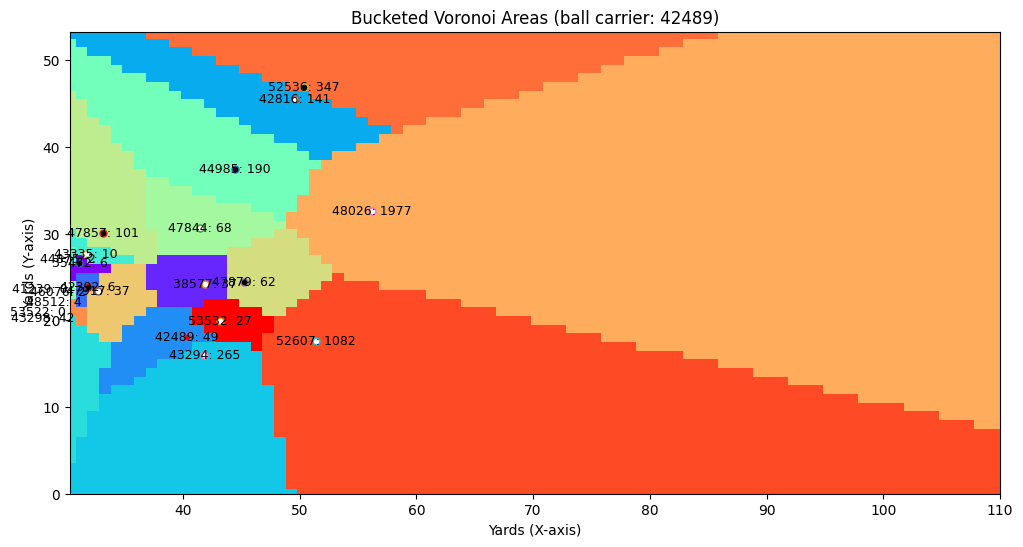

In [53]:
visualize_field(test_frame, x_min=x_min)

In [52]:
for key in areas.keys(): 
    print(f'{key}: {voronoi_areas[key]-areas[key]}')


35472: 1.3758125297780648
38577: 2.4956884814539393
42392: -3.771220465332565
42489: -11.504685080566254
42816: 7.147994850822471
43294: 1.3125922091224993
43335: -0.4738170982714891
44875: 0.1020043476989243
44985: 1.39682131404399
47844: 0.05563033350159685
47857: 3.2826202387108196
47879: 0.013918746962190198
47917: -20.145293328764332
48026: 63.66706301491263
52536: 62.36190460197622
52607: 35.11570495662909
53532: 0.5672603473222395


In [54]:
start = time.time()
for i in range(100): 
    calculate_voronoi_areas(test_frame)
print("Geometric method: ", time.time()-start)
start = time.time()
for i in range(100): 
    assign_squares_to_players(test_frame, x_step=1, y_step=1)
print("Squares method: ", time.time()-start)

Geometric method:  0.40864992141723633


KeyboardInterrupt: 

Setup Time:  0.010677099227905273
Set Dimensions Time:  0.00026869773864746094
Plotting Time:  2.786119222640991
Total Execution Time:  2.7973198890686035


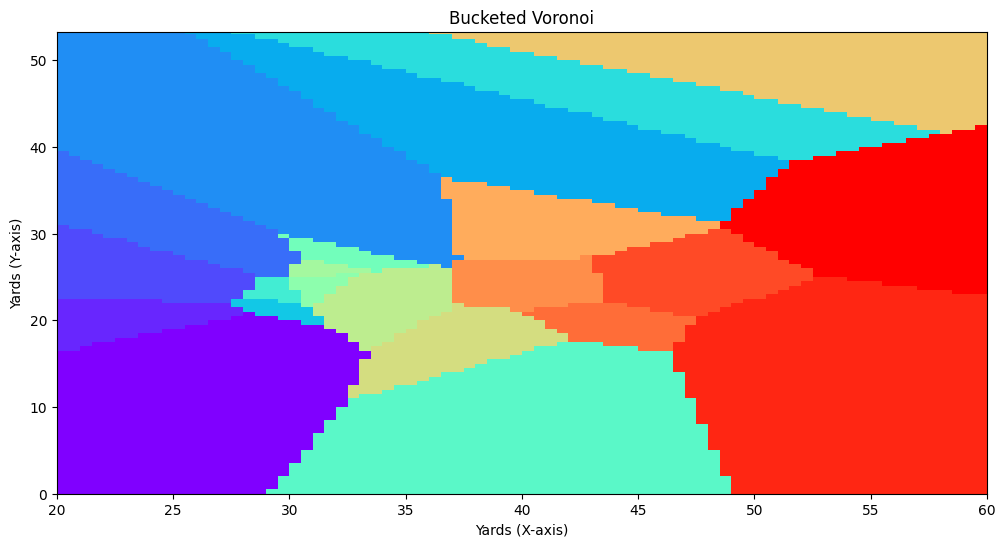

(<Figure size 1200x600 with 1 Axes>,
 <AxesSubplot: title={'center': 'Bucketed Voronoi'}, xlabel='Yards (X-axis)', ylabel='Yards (Y-axis)'>)

In [35]:
visualize_field(squares, min_x=20, max_x=60)

In [ ]:
tackle_percentage_contribution_per_frame(test_frame)

In [ ]:
color_map = generate_color_map(squares.closest_player_id)
visualize_field(squares, color_map)

In [ ]:
test_dict = game_data_organized[56]
create_animation(test_dict, x_min=50, x_max=90, x_step=.3, y_step=.3, frame=56)

In [ ]:
game_file = './data/games.csv'
players_file = './data/players.csv'
games = pd.read_csv(game_file)
players = pd.read_csv(players_file)

game_tpc_file = open('./games/2022090800_LA_BUF/game_tpc.json')
game_tpc = json.load(game_tpc_file)
sorted_game_tpc = sorted(game_tpc.items(), key=lambda x: x[1], reverse=True)
labeled_dict = {}

for id, score in sorted_game_tpc: 
    key = players[players.nflId==int(id)].iloc[0].displayName
    labeled_dict[key] = score
json.dump(labeled_dict, open('./games/2022090800_LA_BUF/labeled_game_tpc.json', 'w'))



for player, score in sorted_game_tpc: 
    jugador = players[players.nflId==int(player)].iloc[0]
    print(jugador.displayName, jugador.position, 'TPC over game: ', score)

### Take 1: TPC

In [ ]:
week_1_tracking_file = './data/tracking_week_1.csv'
plays_file = './data/plays.csv'
game_data = load_game_data(week_1_tracking_file, plays_file, 2022090800)
game_data_organized = organize_game_data(game_data)

In [ ]:
game_tpc = tackle_percentage_contribution_per_game(game_data_organized=game_data_organized)

In [ ]:
game_file = './data/games.csv'
players_file = './data/players.csv'
games = pd.read_csv(game_file)
players = pd.read_csv(players_file)
print(games[games.gameId==2022090800])
sorted_game_tpc = sorted(game_tpc.items(), key=lambda x: x[1], reverse=True)
for key, value in sorted_game_tpc: 
    player = players[players.nflId==key].iloc[0]
    print(player.displayName, "TPC over game: ", value)


### Take 2: Parallelized code

In [ ]:
games_file = './adata/games.csv'
games = pd.read_csv(games_file)
games.head(10)

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31
1,2022091100,2022,1,09/11/2022,13:00:00,ATL,NO,26,27
2,2022091101,2022,1,09/11/2022,13:00:00,CAR,CLE,24,26
3,2022091102,2022,1,09/11/2022,13:00:00,CHI,SF,19,10
4,2022091103,2022,1,09/11/2022,13:00:00,CIN,PIT,20,23
5,2022091104,2022,1,09/11/2022,13:00:00,DET,PHI,35,38
6,2022091105,2022,1,09/11/2022,13:00:00,HOU,IND,20,20
7,2022091106,2022,1,09/11/2022,13:00:00,MIA,NE,20,7
8,2022091107,2022,1,09/11/2022,13:00:00,NYJ,BAL,9,24
9,2022091109,2022,1,09/11/2022,13:00:00,WAS,JAX,28,22


In [ ]:
plays_file = './data/games.csv'
plays = pd.read_csv(plays_file)
plays.head()

In [ ]:
LA_BUF_20220908 = NFLUtils.analyze_game(game_id=2022090800, tracking_file='./data/tracking_week_1.csv')

In [ ]:
ATL_NO_20220911 = NFLUtils.analyze_game(game_id=2022091100, tracking_file='./data/tracking_week_1.csv')

In [ ]:
CAR_CLE_20220911 = NFLUtils.analyze_game(game_id=2022091101, tracking_file='./data/tracking_week_1.csv')

158
85
109
272
296
184
251
213
361
382
417
489
521
542
620
Error processing play 361: 44820
641
662
748
850
993
1077
1101
1516
1720
1744
Error processing play 993: 44898
1785
1901
1945
1980
Error processing play 1516: 46104
2051
2320
2341
2365
Error processing play 1101: 44820
2386
Error processing play 2051: 46104
2407
2478
2501
Error processing play 2386: 46104
2545
Error processing play 2407: 44898
2629
Error processing play 2501: 44898
2683
2783
2832
2909
2930
Error processing play 2629: 44820
2951
3040
3080
3101
3125
3221
Error processing play 3125: 44820
3263
Error processing play 3040: 44820
3315
3336
3357
3378
Error processing play 3336: 44898
3399
3545
3569
3591
Error processing play 3315: 46104
3615
3669
3707
3789
3841
3862
3923
Error processing play 3615: 46104
3961
Error processing play 3569: 46104
4068
4104
4150
Error processing play 3789: 46093


In [ ]:
CHI_SF_20220911 = NFLUtils.analyze_game(game_id=2022091102, tracking_file='./data/tracking_week_1.csv')

145
343
322
364
86
531
467
574
Error processing play 343: 47856
698
Error processing play 86: 47856
756
Error processing play 531: 53623
800
900
921
989
1029
Error processing play 921: 53623
1050
1162
Error processing play 900: 53623
1265
1363
Error processing play 989: 47856
1406
1472
1493
1517
1588
1631
Error processing play 1472: 46377
1794
1837
Error processing play 1050: 47856
1869
1954
Error processing play 1588: 46377
2065
Error processing play 1794: 53646
2132
2238
2281
2352
2394
2415
Error processing play 2394: 46377
2511
2532
Error processing play 2352: 46377
2556
2618
2717
2738
Error processing play 2511: 47856
2759
Error processing play 2618: 47856
2783
2945
Error processing play 2556: 47856
3022
3043
3336
3381
3428
Error processing play 2783: 46377
3470
3502
Error processing play 3502: 53646
3628
3695
Error processing play 2738: 47819
3783
3859
3943
3981
4019
Error processing play 3943: 47856


rosetta error: ThreadContext::resume failed 4


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [ ]:
CIN_PIT_20220911 = NFLUtils.analyze_game(game_id=2022091103, tracking_file='./data/tracking_week_1.csv')

58
295
319
364
274
253
388
340
Error processing play 388: 44860
520
611
632
719
743
Error processing play 743: 53453
764
881
Error processing play 764: 53453
902
955
1037
Error processing play 881: 44860
1105
1126
1150
1171
1228
1315
Error processing play 1228: 52457
1336
1363
1384
1493
1565
1589
Error processing play 1384: 44860
1610
1648
Error processing play 1610: 44860
1700
Error processing play 1589: 44860
1926
1947
2037
Error processing play 1363: 44860
2058
2201
2222
2291
Error processing play 2201: 44860
2315
2483
2511
Error processing play 2511: 53453
2569
2611
2670
2719
2780
Error processing play 2483: 53453
2907
2931
Error processing play 2037: 53453
2955
2976
3011


rosetta error: ThreadContext::resume failed 268435459


KeyboardInterrupt: 

In [ ]:
start_time = time.time()
for label, row in games.iterrows(): 
    print(time.time - start_time)
    try: 
        print(row)
        game_id = row.gameId
        week = row.week
        results = NFLUtils.analyze_game(game_id=game_id, tracking_file=f'./data/tracking_week_{week}.csv')
        time.sleep(30)  # doing this to not melt my processor overnight
    except: 
        continue

gameId               2022090800
season                     2022
week                          1
gameDate             09/08/2022
gameTimeEastern        20:20:00
homeTeamAbbr                 LA
visitorTeamAbbr             BUF
homeFinalScore               10
visitorFinalScore            31
Name: 0, dtype: object
56
101
167
122
146
191
212
299
343
393
414
Error processing play 191: 52494
486
Error processing play 299: 47853
529
569
593
Error processing play 393: 47853
617
646
692
775
818
933
1030
1102
1187
1230
1254
1334
Error processing play 1102: 52494
1358
1385
1406
1712
Error processing play 1187: 47853
1736
1836
Error processing play 1358: 44881
1946
1967
2043
2072
2163
2184
2208
2336
2360
2485
2506
2527
2551
2572
2599
2688
2815
2860
2884
2934
Error processing play 2506: 52494
3121
3145
3166
Error processing play 2551: 52494
3190
3283
Error processing play 3121: 43399
3341
3362
3383
3407
3431
Error processing play 3283: 47857
3489
3513
Error processing play 3145: 47853
3576
3636
gameI

rosetta error: thread_suspend failed


gameId               2022091101
season                     2022
week                          1
gameDate             09/11/2022
gameTimeEastern        13:00:00
homeTeamAbbr                CAR
visitorTeamAbbr             CLE
homeFinalScore               24
visitorFinalScore            26
Name: 2, dtype: object
213
158
184
85
109
251
296
272
361
382
417
489
521
542
620
Error processing play 361: 44820
641
662
748
850


rosetta error: ThreadContext::resume failed 268435459


gameId               2022091102
season                     2022
week                          1
gameDate             09/11/2022
gameTimeEastern        13:00:00
homeTeamAbbr                CHI
visitorTeamAbbr              SF
homeFinalScore               19
visitorFinalScore            10
Name: 3, dtype: object
364
343
86
322
145
531
574
467


### Cross check with faster Voronoi utils

In [67]:
games_file = './data/games.csv'
games = pd.read_csv(games_file)

start_time = time.time()
for label, row in games.iterrows(): 
    print(f"{label} ---- cumulative runtime: ", time.time() - start_time)
    try: 
        print(row)
        game_id = row.gameId
        week = row.week
        results = analyze_game_unparallelized(game_id=game_id, tracking_file=f'./data/tracking_week_{week}.csv')
    except Exception as e: 
        print(e)
        continue

0 ---- cumulative runtime:  0.0003662109375
gameId               2022090800
season                     2022
week                          1
gameDate             09/08/2022
gameTimeEastern        20:20:00
homeTeamAbbr                 LA
visitorTeamAbbr             BUF
homeFinalScore               10
visitorFinalScore            31
Name: 0, dtype: object
56
101
122
146
167
191
212
299
343
393
414
486
529
569
593
617
646
692
775
818
933
1030
1102
1187
1230
1254
1334
1358
1385
1406
1712
1736
1836
1946
1967
2043
2072
2163
2184
2208
2336
2360
2485
2506
2527
2551
2572
2599
2688
2815
2860
2884
2934
3121
3145
3166
3190
3283
3341
3362
3383
3407
3431
3489
3513
3576
3636
1 ---- cumulative runtime:  93.10582113265991
gameId               2022091100
season                     2022
week                          1
gameDate             09/11/2022
gameTimeEastern        13:00:00
homeTeamAbbr                ATL
visitorTeamAbbr              NO
homeFinalScore               26
visitorFinalScore            2

### Add Euclidean distances to the plays

In [32]:
euclidean_distance_per_frame(test_frame)

{38577: 6.323171672507403,
 41239: 13.748810857670572,
 42816: 28.985686122636462,
 43294: 2.576198750096735,
 43298: 12.550776868385478,
 43335: 12.879072171550245,
 47844: 12.613453135442334,
 47917: 9.240936099768255,
 48026: 21.516918924418523,
 52607: 11.101265693604494,
 53532: 3.3894099781525435}

In [36]:
euclidean_distance_per_play(game_data_organized[56], filepath='.')

{6: {38577: 7.067538468236311,
  41239: 13.52726505987076,
  42816: 29.415604702266453,
  43294: 2.828002828852891,
  43298: 12.502403768875814,
  43335: 13.117819940828587,
  47844: 13.373335410435201,
  47917: 9.53441136095984,
  48026: 21.893599521321295,
  52607: 11.450921360309831,
  53532: 3.8512984823303453},
 7: {38577: 6.323171672507403,
  41239: 13.748810857670572,
  42816: 28.985686122636462,
  43294: 2.576198750096735,
  43298: 12.550776868385478,
  43335: 12.879072171550245,
  47844: 12.613453135442334,
  47917: 9.240936099768255,
  48026: 21.516918924418523,
  52607: 11.101265693604494,
  53532: 3.3894099781525435},
 8: {38577: 5.627361726422076,
  41239: 13.950232972964997,
  42816: 28.58221125105614,
  43294: 2.3041701326073984,
  43298: 12.586711246389974,
  43335: 12.685286752769912,
  47844: 11.904641951776629,
  47917: 9.002694041230102,
  48026: 21.135089306648325,
  52607: 10.719449612736662,
  53532: 2.9652150006365536},
 9: {38577: 4.982579653151566,
  41239: 14

In [33]:
games_file = './data/games.csv'
games = pd.read_csv(games_file)

start_time = time.time()
for label, row in games.iterrows(): 
    print(f"{label} ---- cumulative runtime: ", time.time() - start_time)
    try: 
        print(row)
        game_id = row.gameId
        week = row.week
        results = analyze_game_distances(game_id=game_id, tracking_file=f'./data/tracking_week_{week}.csv')
    except Exception as e: 
        print(e)
        continue

0 ---- cumulative runtime:  0.0002758502960205078
gameId               2022090800
season                     2022
week                          1
gameDate             09/08/2022
gameTimeEastern        20:20:00
homeTeamAbbr                 LA
visitorTeamAbbr             BUF
homeFinalScore               10
visitorFinalScore            31
Name: 0, dtype: object
module 'utils' has no attribute 'analyze_game_distances'
1 ---- cumulative runtime:  0.0009257793426513672
gameId               2022091100
season                     2022
week                          1
gameDate             09/11/2022
gameTimeEastern        13:00:00
homeTeamAbbr                ATL
visitorTeamAbbr              NO
homeFinalScore               26
visitorFinalScore            27
Name: 1, dtype: object
module 'utils' has no attribute 'analyze_game_distances'
2 ---- cumulative runtime:  0.0012080669403076172
gameId               2022091101
season                     2022
week                          1
gameDate          

## Results

### Sanity check: best defensive players first half of season

In [66]:
def filter_tackles_by_folders(tackles:pd.DataFrame, games_folder:str='./games', analysis_filename:str='tpc_per_frame_updated_voronoi.csv')->pd.DataFrame:
    """ 
    Given a dataframe of all tackles, this will walk through the directory and return only the tackle data for the plays for which we have voronoi analysis and data in tackles.csv
    Params: 
    - games_folder (int): the filepath of games folder
    - tackles_df: the dataframe of all tackles (read from ./data/tackles.csv)
    - analysis_filename (str): the name of the files holding the data from the voronoi analysis for each play
    Returns: 
    - filtered_tackles (pd.DataFrame): a data frame with all the relevant plays and tackles/assists
    """
    filtered_tackles = pd.DataFrame(columns=['gameId', 'playId'])

    for root, _, files in os.walk(games_folder):
        for file in files:
            if file.endswith(analysis_filename):
                # Extract gameId and playId from the folder structure
                game_folder = os.path.basename(os.path.dirname(root))
                play_id = int(os.path.basename(root))
                game_id = int(game_folder.split('_')[0])

                # Check if there is a matching row in the 'tackles' DataFrame
                match = (tackles['gameId'] == game_id) & (tackles['playId'] == play_id)

                if match.any():
                    # Append matching rows to the filtered_tackles DataFrame
                    filtered_tackles = pd.concat([filtered_tackles, tackles[match]])
                else: 
                    print("NOT FOUND")

    return filtered_tackles
    

In [73]:
def load_tpc_tackles():    
    """ 
    Load the tackles based on TPC numbers
    Returns: 
    - tpc_tackles_per_player (dict): key is the nflId, value is the total tackles in the season based on TPC
    """
    tpc_tackles_per_player = {}
    for gameId, home, visiting in zip(games.gameId, games.homeTeamAbbr, games.visitorTeamAbbr): 
        with open(f'./games/{gameId}_{home}_{visiting}/game_tpc.json') as json_file:
            data = json.load(json_file)
            for key, value in data.items(): 
                tpc_tackles_per_player[int(key)] = tpc_tackles_per_player.get(int(key), 0) + value
    return tpc_tackles_per_player

In [152]:
# filter relevant tackles
games = pd.read_csv('./data/games.csv')
players = pd.read_csv('./data/players.csv')
all_tackles = pd.read_csv("./data/tackles.csv")

# get only the relevant tackles
relevant_tackles = filter_tackles_by_folders(all_tackles)
# get a map of nflId to players
players_dict = {nflId: players[players.nflId==int(nflId)].displayName.iloc[0] for nflId in players.nflId}

NOT FOUND
NOT FOUND
NOT FOUND
NOT FOUND


In [153]:
# recorded tackles/assists
recorded_tackles_per_play = {}
# Group the DataFrame by 'gameId' and 'playId' and apply the custom function
relevant_tackles_grouped = relevant_tackles.groupby(['gameId', 'playId']).sum()

# normalize it such that assists sum up to 1
for (game_id, play_id), group_data in relevant_tackles_grouped.iterrows():
    recorded_tackles_per_play[(game_id, play_id)] = (group_data['tackle'], group_data['assist'])
    # print(group_data['tackle'], group_data['assist']) # what's up with the total plays

print(len(relevant_tackles_grouped)) # sanity check the number of tackles

9456


In [155]:
# Group the DataFrame by 'gameId' and 'playId' and calculate the sum of assists
assist_sums = relevant_tackles.groupby(['gameId', 'playId'])['assist'].sum().reset_index()

# Normalize assists in the original DataFrame such that they always sum to 1
counter = 0
for (gameId, playId), (tackles, assists) in recorded_tackles_per_play.items(): 
    total = tackles + .5 * assists
    # one tackle, one assist 
    if total==1.5 and tackles==1: 
        relevant_tackles.loc[(relevant_tackles['gameId'] == gameId) & (relevant_tackles['playId'] == playId) & (relevant_tackles['assist']>0), 'assist'] = assists*.5/total
        relevant_tackles.loc[(relevant_tackles['gameId'] == gameId) & (relevant_tackles['playId'] == playId) & (relevant_tackles['tackle']>0), 'tackle'] = tackles/total
    elif assists==2.0: 
        relevant_tackles.loc[(relevant_tackles['gameId'] == gameId) & (relevant_tackles['playId'] == playId), 'assist'] = assists/4
    elif assists==3.0: 
        relevant_tackles.loc[(relevant_tackles['gameId'] == gameId) & (relevant_tackles['playId'] == playId), 'assist'] = assists/6
    elif assists==4.0: 
        relevant_tackles.loc[(relevant_tackles['gameId'] == gameId) & (relevant_tackles['playId'] == playId), 'assist'] = assists/8
    elif total != 1: 
        print((gameId, playId), (tackles, assists))


In [156]:
relevant_tackles_updated_grouped = relevant_tackles.groupby(['gameId', 'playId']).sum()
for (gameId, playId), row in relevant_tackles_updated_grouped.iterrows(): 
    if row.tackle + row.assist != 1: 
        print((gameId, playId), row.tackle, row.assist)

(2022091100, 2069) 0.0 1.5
(2022091100, 2491) 0.0 1.5
(2022091101, 296) 0.0 1.5
(2022091101, 382) 0.0 1.5
(2022091101, 641) 0.0 2.0
(2022091101, 1980) 0.0 1.5
(2022091101, 2365) 0.0 2.0
(2022091101, 2407) 0.0 1.5
(2022091101, 3615) 0.0 1.5
(2022091102, 698) 0.0 1.5
(2022091102, 3695) 0.0 1.5
(2022091103, 1363) 0.0 1.5
(2022091105, 101) 0.0 1.5
(2022091105, 403) 0.0 1.5
(2022091106, 130) 0.0 1.5
(2022091106, 2191) 0.0 2.0
(2022091106, 2840) 0.0 2.0
(2022091108, 3177) 0.0 1.5
(2022091110, 2810) 0.0 1.5
(2022091112, 3002) 0.0 1.5
(2022091112, 3416) 0.0 2.0
(2022091200, 622) 0.0 2.0
(2022091200, 1680) 0.0 1.5
(2022091500, 2987) 0.0 1.5
(2022091500, 3780) 0.0 2.0
(2022091801, 885) 0.0 1.5
(2022091801, 2550) 0.0 2.0
(2022091801, 3416) 0.0 2.0
(2022091802, 2330) 0.0 2.0
(2022091803, 2300) 0.0 1.5
(2022091803, 2592) 0.0 1.5
(2022091805, 823) 0.0 1.5
(2022091805, 3424) 0.0 1.5
(2022091806, 2146) 0.0 1.5
(2022091806, 3131) 0.0 1.5
(2022091807, 1294) 0.0 1.5
(2022091807, 1902) 0.0 1.5
(2022091807

In [157]:
# get the recorded tackle numbers (based on ./data/tackles.csv)
recorded_tackles_per_player = {}
relevant_tackles_grouped_by_player = relevant_tackles.groupby(['nflId'])[['tackle', 'assist']].sum(numeric_only=False)
for nflId, row in relevant_tackles_grouped_by_player.iterrows(): 
    recorded_tackles_per_player[int(nflId)] = row.tackle + row.assist

# get the tpc tackle numbers
tpc_tackles_per_player = load_tpc_tackles()

In [120]:
# sort the defenders from highest to lowest to see if this makes sense
total_defended_sorted = sorted(tpc_tackles_per_player.items(), key=lambda x: x[1],reverse=True)
for nflId, tpc in total_defended_sorted: 
    print(players_dict[nflId], tpc)

Jalen Thompson 41.67244546033307
Eddie Jackson 40.384967389611866
Mike Edwards 40.09919893093222
Andre Cisco 39.483833838445406
Xavier Woods 39.17751095916074
Mykal Walker 37.61302685837185
Shaq Thompson 37.12071966505545
Bobby Okereke 36.17772507156644
Rashaan Evans 36.05548616891245
Pete Werner 35.93859734700848
Myles Jack 35.882225961675616
John Johnson 35.39662000931649
Derwin James 35.32659032585335
Devin Lloyd 35.162176373084876
C.J. Mosley 34.97460626914966
Kyler Gordon 34.79258606181954
Kareem Jackson 34.76793436321497
Richie Grant 34.60268224851326
Vonn Bell 34.43750337655877
De'Vondre Campbell 34.24245033335821
Foyesade Oluokun 34.22388181721457
Rayshawn Jenkins 34.11179962868052
Steven Nelson 33.99617531427987
Minkah Fitzpatrick 33.38922388496112
Budda Baker 33.049182672111435
Cameron Dantzler 32.86511502217412
Tyrann Mathieu 32.8563430607455
Kenny Moore 32.85376045104319
Jordyn Brooks 32.77162511312184
Nick Bolton 32.755323649595944
Jaylinn Hawkins 32.59726508951793
Zaven C

In [158]:
print("total tackles (recorded_tackles_per_player, tpc_tackles_per_player):", sum(recorded_tackles_per_player.values()), sum(tpc_tackles_per_player.values()))

total tackles (recorded_tackles_per_player, tpc_tackles_per_player): 9589.99999999999 9459.999999999998


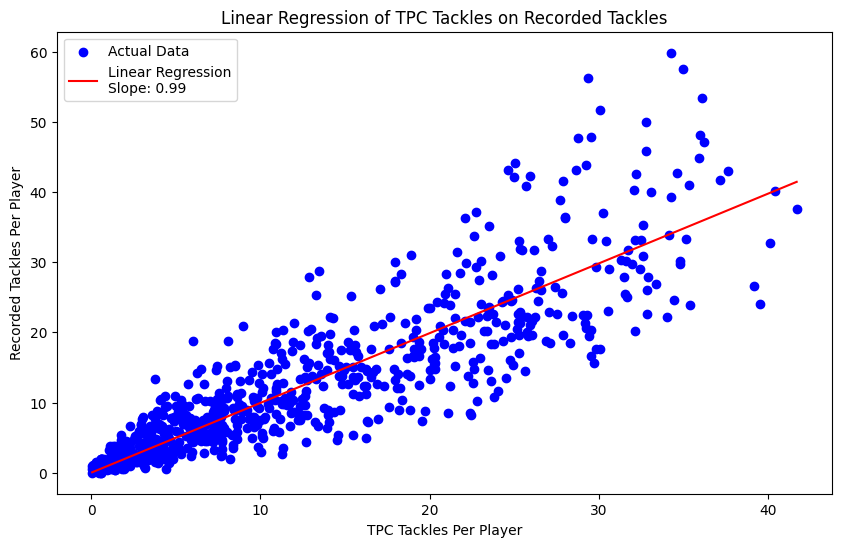

In [161]:
from sklearn.linear_model import LinearRegression

# Prepare data
common_keys = set(tpc_tackles_per_player.keys()) & set(recorded_tackles_per_player.keys())
x = np.array([tpc_tackles_per_player[key] for key in common_keys]).reshape(-1, 1)
y = np.array([recorded_tackles_per_player[key] for key in common_keys])

# Linear regression without intercept
model = LinearRegression(fit_intercept=False)
model.fit(x, y)

# Predictions for plotting
x_range = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
y_pred = model.predict(x_range)

# Get the slope (coefficient)
slope = model.coef_[0]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', label='Actual Data')
plt.plot(x_range, y_pred, color='red', label=f'Linear Regression\nSlope: {slope:.2f}')
plt.xlabel('TPC Tackles Per Player')
plt.ylabel('Recorded Tackles Per Player')
plt.title('Linear Regression of TPC Tackles on Recorded Tackles')
plt.legend()
plt.show()

R-squared: 0.768311440572238
Mean Absolute Error: 3.560528194081017
Coefficient t-score: 52.87805047440489


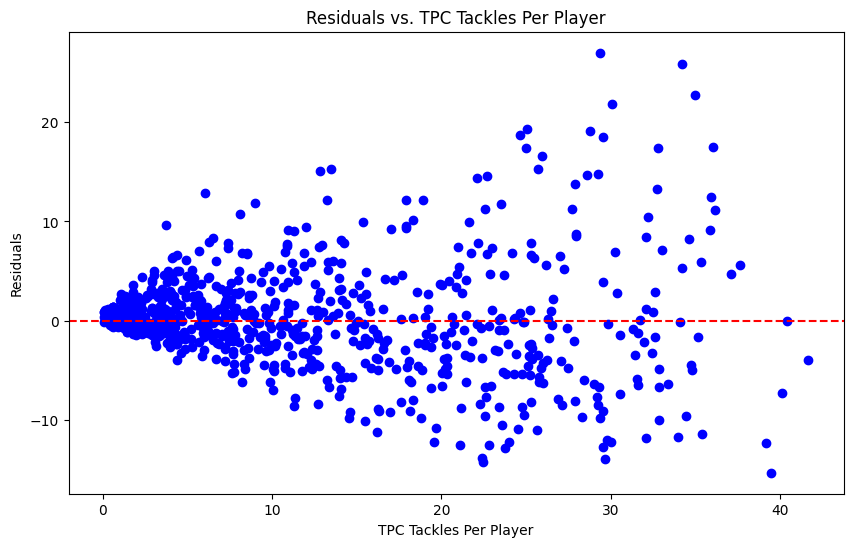

In [162]:
from sklearn.metrics import mean_absolute_error
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Assuming x and y are already defined as per previous examples

# Fit the model
model = LinearRegression(fit_intercept=False)
model.fit(x, y)

# Predictions
y_pred = model.predict(x)

# Residuals
residuals = y - y_pred

# Calculate R-squared
r_squared = model.score(x, y)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y, y_pred)

# Calculate the t-score for the coefficient
# Note: This is a simplified calculation and assumes large sample size
stderr = np.sqrt(np.mean(residuals**2) / np.sum((x - np.mean(x))**2))
t_score = model.coef_[0] / stderr

# Printing statistics
print(f"R-squared: {r_squared}")
print(f"Mean Absolute Error: {mae}")
print(f"Coefficient t-score: {t_score}")

# Plotting residuals
plt.figure(figsize=(10, 6))
plt.scatter(x, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('TPC Tackles Per Player')
plt.ylabel('Residuals')
plt.title('Residuals vs. TPC Tackles Per Player')
plt.show()


/var/folders/t4/wbzk7n1x307bpf5mwlmj_z3c0000gn/T/ipykernel_38859/2482949756.py:7: RuntimeWarning: divide by zero encountered in divide
  percent_residuals = residuals / y


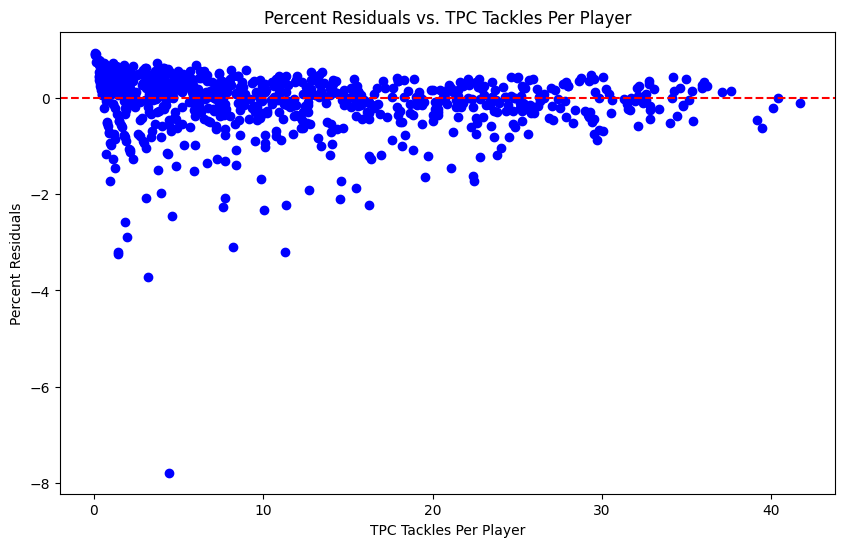

LinAlgError: SVD did not converge

In [166]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Assuming residuals and y are already defined

# Calculate percent residuals (avoid division by zero)
percent_residuals = residuals / y

# Plotting percent residuals
plt.figure(figsize=(10, 6))
plt.scatter(x, percent_residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('TPC Tackles Per Player')
plt.ylabel('Percent Residuals')
plt.title('Percent Residuals vs. TPC Tackles Per Player')
plt.show()

# Run ADF test
adf_result = adfuller(percent_residuals)
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
for key, value in adf_result[4].items():
    print(f'Critical Value {key}: {value}')

# Interpretation of ADF test
if adf_result[1] < 0.05:
    print("Evidence against the null hypothesis (stationary)")
else:
    print("No evidence against the null hypothesis (non-stationary)")


### Distance weighted TPC

In [2]:
def process_play_folder(play_folder):
    """
    Process a single play folder, calculating the dot product of distances and TPC,
    and saving the result as 'distance_weighted_tpc.csv'.
    """
    distance_file = os.path.join(play_folder, 'distances_per_frame.csv')
    tpc_file = os.path.join(play_folder, 'tpc_per_frame_updated_voronoi.csv')

    # Read the CSV files
    distances_df = pd.read_csv(distance_file, index_col=0)
    tpc_df = pd.read_csv(tpc_file, index_col=0)

    # Ensure the columns are in the same order
    distances_df = distances_df[tpc_df.columns]

    # Compute the dot product
    result_df = distances_df * tpc_df

    # Save the result
    result_file = os.path.join(play_folder, 'distance_weighted_tpc.csv')
    result_df.to_csv(result_file)

def process_games_folder(games_folder='./games'):
    """
    Walk through the games folder, processing each play folder.
    """
    for root, dirs, files in os.walk(games_folder):
        if 'distances_per_frame.csv' in files and 'tpc_per_frame_updated_voronoi.csv' in files:
            process_play_folder(root)

# Call the function to process the games folder
process_games_folder()


In [3]:
def calculate_and_save_percent_contribution(csv_file, json_file):
    # Read the CSV file
    df = pd.read_csv(csv_file, index_col=0)

    # Calculate the sum of each column and the total sum
    column_sums = df.sum()
    total_sum = column_sums.sum()

    # Compute the percent contribution for each column
    percent_contributions = (column_sums / total_sum) * 100

    # Convert to dictionary and save as JSON
    percent_contribution_dict = percent_contributions.to_dict()
    with open(json_file, 'w') as f:
        json.dump(percent_contribution_dict, f)

def process_games_folder(games_folder='./games'):
    for root, dirs, files in os.walk(games_folder):
        if 'distance_weighted_tpc.csv' in files:
            csv_file = os.path.join(root, 'distance_weighted_tpc.csv')
            json_file = os.path.join(root, 'distance_weighted_tpc.json')
            calculate_and_save_percent_contribution(csv_file, json_file)

# Call the function to process the games folder
process_games_folder()


In [4]:
import os
import json

def process_game_folder(game_folder):
    """
    Process a single game folder, summing each play's distance_weighted_tpc.json
    for each player and saving the result in distance_weighted_game_tpc.json.
    """
    game_tpc = {}

    # Iterate through each play's folder in the game
    for play_folder in os.listdir(game_folder):
        play_path = os.path.join(game_folder, play_folder)
        if os.path.isdir(play_path):
            json_file = os.path.join(play_path, 'distance_weighted_tpc.json')
            if os.path.exists(json_file):
                with open(json_file, 'r') as f:
                    play_tpc = json.load(f)
                    for player, contribution in play_tpc.items():
                        game_tpc[player] = game_tpc.get(player, 0) + contribution

    # Save the aggregated result
    json_output_path = os.path.join(game_folder, 'distance_weighted_game_tpc.json')
    with open(json_output_path, 'w') as f:
        json.dump(game_tpc, f)

def process_games_folder(games_folder='./games'):
    """
    Walk through the games folder, processing each game folder.
    """
    for game_folder in os.listdir(games_folder):
        game_path = os.path.join(games_folder, game_folder)
        if os.path.isdir(game_path):
            process_game_folder(game_path)

# Call the function to process the games folder
process_games_folder()
